# Team Members

# Class Imbalance 1: Celecstial Object Classification

# Load Required Libraries

In [2]:
import numpy as np
import pandas as pd
import re
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Data Cleaning and EDA

### Read data and drop columns

In [11]:
df = pd.read_csv("celestial_object_classify.csv")
# df_test = pd.read_csv("fake.news.test.csv")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 43 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ObjectID                   100000 non-null  float64
 1   SpectrographObjectID       100000 non-null  float64
 2   RightAscension             100000 non-null  float64
 3   Declination                100000 non-null  float64
 4   UltravioletMagnitude       100000 non-null  float64
 5   GreenMagnitude             100000 non-null  float64
 6   RedMagnitude               100000 non-null  float64
 7   InfraredMagnitude          100000 non-null  float64
 8   NearInfraredMagnitude      100000 non-null  float64
 9   RunNumber                  100000 non-null  int64  
 10  DataRerunNumber            100000 non-null  int64  
 11  CameraColumnNumber         100000 non-null  int64  
 12  FieldNumber                100000 non-null  int64  
 13  PlateNumber                100

In [13]:
df.drop(columns=['ObjectID', 'SpectrographObjectID', 'RunNumber', 'DataRerunNumber', 'CameraColumnNumber', 'FieldNumber', 'PlateNumber', 'OpticalFiberID'], inplace=True) 
# remove ids from data

In [14]:
df['class'].value_counts()

class
GALAXY    52343
STAR      37232
QSO       10425
Name: count, dtype: int64

In [27]:
df.columns

Index(['RightAscension', 'Declination', 'UltravioletMagnitude',
       'GreenMagnitude', 'RedMagnitude', 'InfraredMagnitude',
       'NearInfraredMagnitude', 'ModifiedJulianDate', 'PetrosianRadiusU',
       'PetrosianRadiusG', 'PetrosianRadiusI', 'PetrosianRadiusI.1',
       'PetrosianRadiusZ', 'PetrosianFluxU', 'PetrosianFluxG',
       'PetrosianFluxR', 'PetrosianFluxI', 'PetrosianFluxZ',
       'PetrosianHalfLightRadiusU', 'PetrosianHalfLightRadiusG',
       'PetrosianHalfLightRadiusR', 'PetrosianHalfLightRadiusI',
       'PetrosianHalfLightRadiusZ', 'PSFMagnitudeU', 'PSFMagnitudeR',
       'PSFMagnitudeG', 'PSFMagnitudeI', 'PSFMagnitudeZ',
       'ExponentialAxisRatioU', 'ExponentialAxisRatioG',
       'ExponentialAxisRatioR', 'ExponentialAxisRatioI',
       'ExponentialAxisRatioZ', 'FinalRedshift', 'class'],
      dtype='object')

### EDA

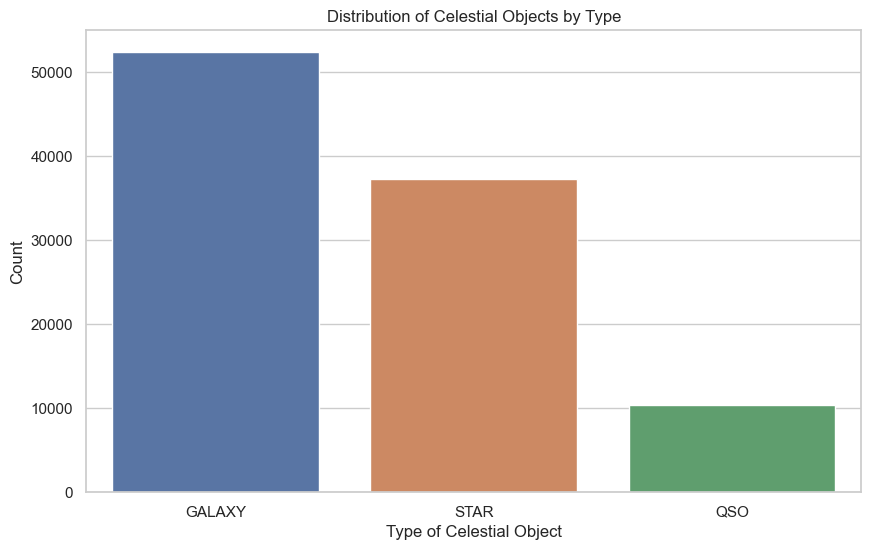

In [15]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=df)
plt.title('Distribution of Celestial Objects by Type')
plt.xlabel('Type of Celestial Object')
plt.ylabel('Count')
plt.show()

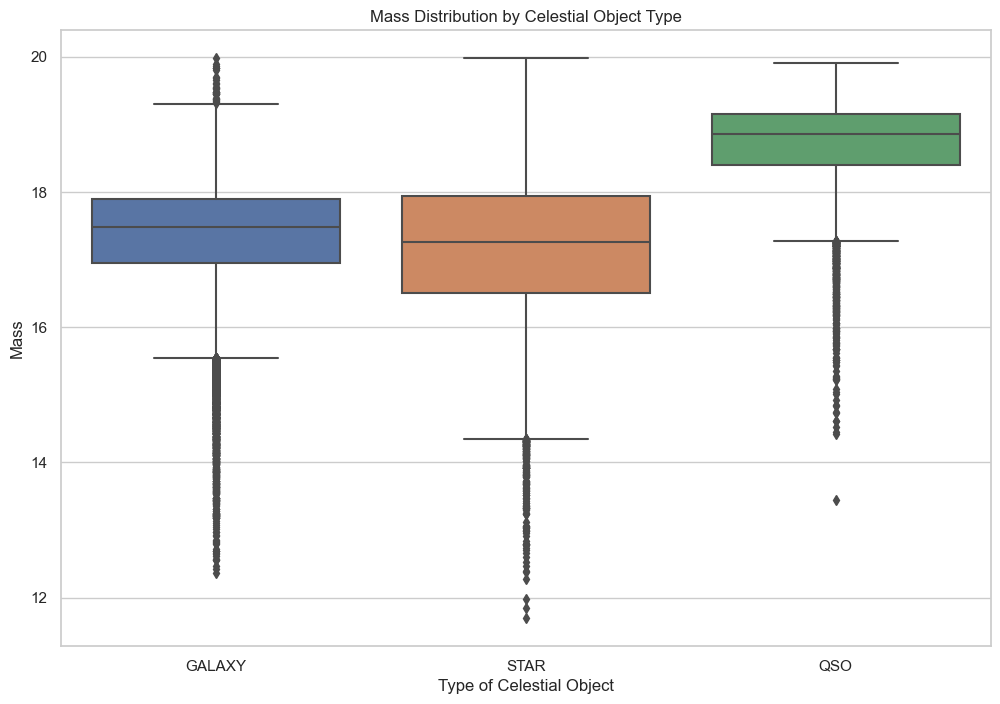

In [18]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='class', y='GreenMagnitude', data=df)
plt.title('Mass Distribution by Celestial Object Type')
plt.xlabel('Type of Celestial Object')
plt.ylabel('Mass')
plt.show()

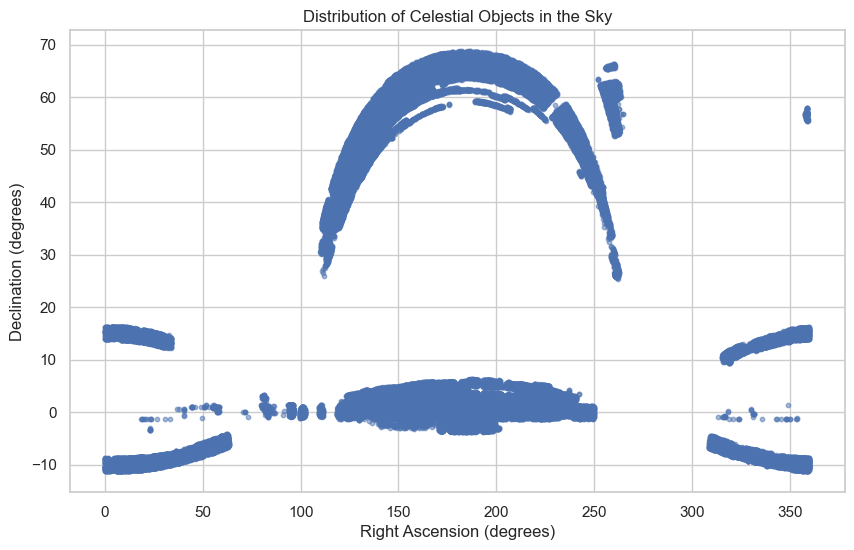

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(df['RightAscension'], df['Declination'], alpha=0.5, s=10)  # Adjust size 's' and transparency 'alpha' as needed
plt.title('Distribution of Celestial Objects in the Sky')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.grid(True)
plt.show()

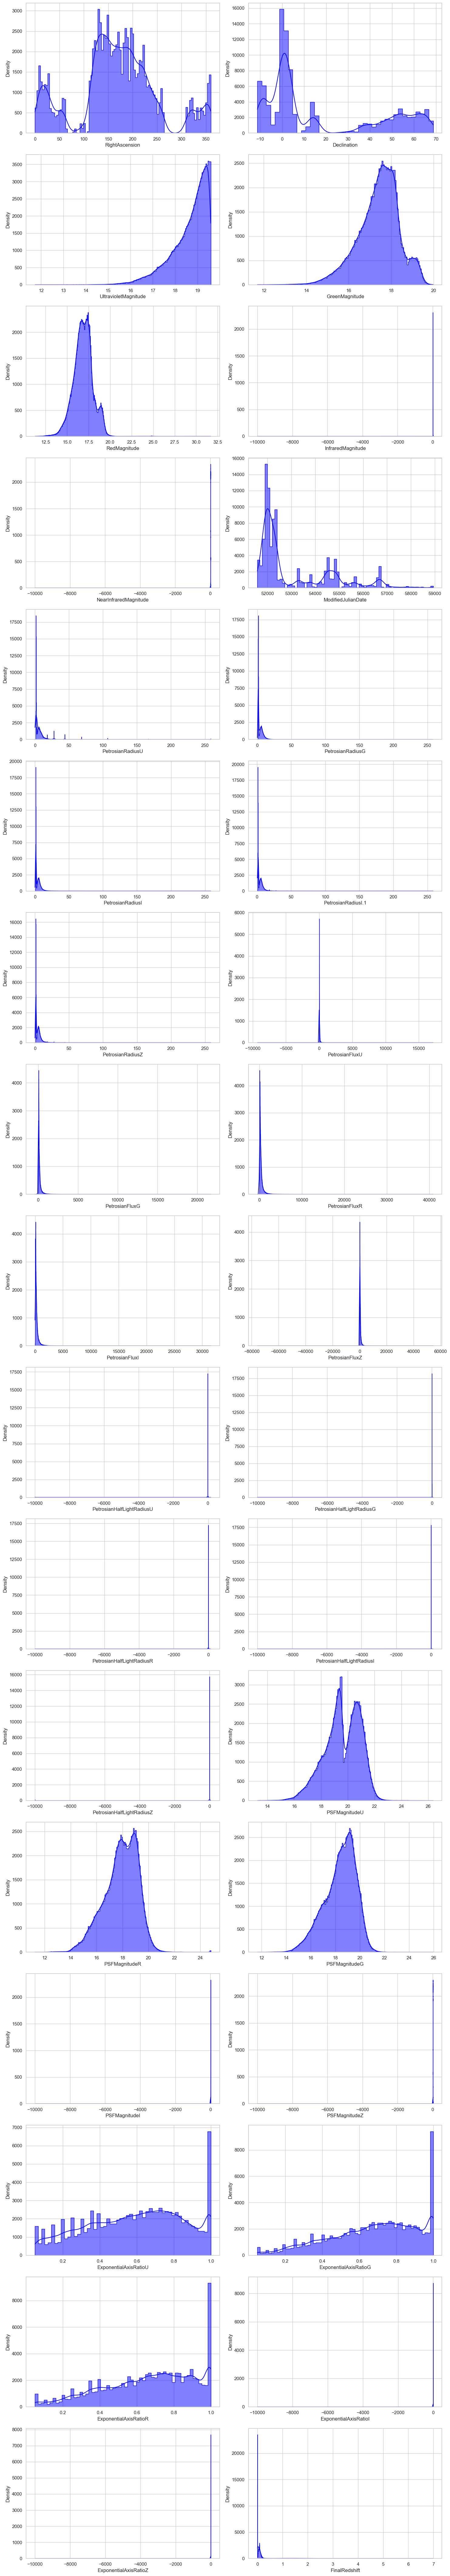

In [28]:
sns.set(style="whitegrid")
num_columns = df.select_dtypes(include=['float64', 'int']).columns.size
num_rows = (num_columns+1) // 2

plt.figure(figsize=(15, 5 * num_rows))

for i, column in enumerate(df.select_dtypes(include=['float64', 'int']).columns):
    plt.subplot(num_rows, 2, i + 1)
    sns.histplot(df[column], kde=True, color='blue', element='step')
    # plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

### Encoding object variables

In [6]:
encoder = LabelEncoder()
df['class'] = encoder.fit_transform(df['class'])

### Feature selection

In [8]:
X = df.drop(columns=['class'])
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
feature_names = X_train.columns

In [8]:
# k_best_selector = SelectKBest(score_func=f_classif, k=15)  # Select 10 best features
# k_best_selector.fit(X, y)

SelectKBest(k=15)

In [9]:
# selected_feature_indices = k_best_selector.get_support(indices=True)
# selected_feature_names = [feature_names[i] for i in selected_feature_indices]
# print(selected_feature_names)

['UltravioletMagnitude', 'GreenMagnitude', 'RedMagnitude', 'ModifiedJulianDate', 'PetrosianRadiusU', 'PetrosianRadiusG', 'PetrosianRadiusI', 'PetrosianRadiusI.1', 'PetrosianRadiusZ', 'PetrosianFluxG', 'PSFMagnitudeU', 'PSFMagnitudeR', 'PSFMagnitudeG', 'ExponentialAxisRatioG', 'FinalRedshift']


In [10]:
# X_train = X_train[selected_feature_names]
# X_test = X_test[selected_feature_names]

Since we have already removed id columns, further feature selection is not necessary. Also, from domain knowledge we can verify that all provided features are necessary for classifying celestial objects.

### Handling class imbalance

#### 1 Random Over Sampler

In [9]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [23]:
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [24]:
unique_values, counts = np.unique(y_resampled, return_counts=True)
print(unique_values)
print(counts)

[0 1 2]
[36715 36715 36715]


#### 2 Class weighting

In [11]:
class_distribution = df['class'].value_counts()

# Calculate inverse frequency weights
total_samples = class_distribution.sum()
class_weights = total_samples / (len(class_distribution) * class_distribution)

class_weights = class_weights.to_dict()

print("Class Weights:")
print(class_weights)

Class Weights:
{0: 0.636825045055372, 2: 0.8952872081363702, 1: 3.1974420463629096}


#### 3 One-Class Learning

In [13]:
class_label = 0
class_df = df[df['class'] == class_label]

X_class = class_df.drop('class', axis=1)
y_class = class_df['class']

X_train_1c, X_test_1c, y_train_1c, y_test_1c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

X_train_1c = X_train_1c[feature_names] # for feature selection use selected_feature_names
X_test_1c = X_test_1c[feature_names]

unique_values_set = set(y_train_1c)
for value in unique_values_set:
    print(value)

0


### Store cleaned dataset

In [15]:
df_cleaned = pd.DataFrame(X_resampled[selected_feature_names])

In [16]:
df_cleaned['target'] = y_resampled

In [17]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110145 entries, 0 to 110144
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   UltravioletMagnitude   110145 non-null  float64
 1   GreenMagnitude         110145 non-null  float64
 2   RedMagnitude           110145 non-null  float64
 3   ModifiedJulianDate     110145 non-null  int64  
 4   PetrosianRadiusU       110145 non-null  float64
 5   PetrosianRadiusG       110145 non-null  float64
 6   PetrosianRadiusI       110145 non-null  float64
 7   PetrosianRadiusI.1     110145 non-null  float64
 8   PetrosianRadiusZ       110145 non-null  float64
 9   PetrosianFluxG         110145 non-null  float64
 10  PSFMagnitudeU          110145 non-null  float64
 11  PSFMagnitudeR          110145 non-null  float64
 12  PSFMagnitudeG          110145 non-null  float64
 13  ExponentialAxisRatioG  110145 non-null  float64
 14  FinalRedshift          110145 non-nu

In [18]:
# df_cleaned.to_csv('celestial_object_classify_cleaned.csv', index=False)

# Model Training

## K-Nearest Neigbours

### with class imbalance

In [38]:
knn_classifier = KNeighborsClassifier()

In [39]:
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [40]:
y_pred1 = knn_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

Accuracy: 0.9211333333333334
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     15628
           1       0.84      0.79      0.81      3164
           2       0.92      0.91      0.91     11208

    accuracy                           0.92     30000
   macro avg       0.90      0.88      0.89     30000
weighted avg       0.92      0.92      0.92     30000



In [18]:
cv_scores = cross_val_score(knn_classifier, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.92075 0.9215  0.92695 0.9181  0.90655]
Mean CV Score: 0.91877


### without class imbalance 1 Random Over Sampler

In [25]:
knn_classifier.fit(X_train_rs, y_train_rs)

KNeighborsClassifier()

In [26]:
y_pred2 = knn_classifier.predict(X_test_rs)
print("Accuracy:", accuracy_score(y_test_rs, y_pred2))
print(classification_report(y_test_rs, y_pred2))

Accuracy: 0.9335875436924055
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7396
           1       0.92      0.97      0.94      7308
           2       0.94      0.91      0.92      7325

    accuracy                           0.93     22029
   macro avg       0.93      0.93      0.93     22029
weighted avg       0.93      0.93      0.93     22029



In [28]:
cv_scores = cross_val_score(knn_classifier, X_resampled, y_resampled, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.9330882  0.93572109 0.93090926 0.93953425 0.94071451]
Mean CV Score: 0.9359934631621953


The precesion for the class with low number of samples has increased from 84% to 92%. Although this accuracy is very good at face value, it might be overfitting the given dataset as KNN is a relatively simple model.

### without class imbalance 2 Class weightingoat64

K-NN cannot use weights to train model as it is a simple model

### without class imbalance 3 One-Class learning

In [29]:
knn_classifier.fit(X_train_1c, y_train_1c)

KNeighborsClassifier()

In [33]:
y_pred1_c = knn_classifier.predict(X_test_1c)
print("Accuracy:", accuracy_score(y_test_1c, y_pred1_c))
print(classification_report(y_test_1c, y_pred1_c))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10469

    accuracy                           1.00     10469
   macro avg       1.00      1.00      1.00     10469
weighted avg       1.00      1.00      1.00     10469



In [36]:
cv_scores = cross_val_score(knn_classifier, X_train_1c, y_train_1c, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0


In [37]:
y_pred1 = knn_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred1))

Accuracy: 0.5209333333333334


These results indicate that KNN is incapable of learning on one-class datasets, at it seems to be overfitting this model. This can be verified by looking at the model's prediction on multiclass dataset after it has been trained on one-class. The accuracy has dropped from 100% to ~52%.

## Logistic Regression

### with class imbalance

In [41]:
lg_classifier = LogisticRegression()
lg_classifier.fit(X_train, y_train)

LogisticRegression()

In [42]:
y_pred5 = lg_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred5))
print(classification_report(y_test, y_pred5))

Accuracy: 0.8299666666666666
              precision    recall  f1-score   support

           0       0.84      0.93      0.89     15628
           1       0.71      0.73      0.72      3164
           2       0.85      0.71      0.78     11208

    accuracy                           0.83     30000
   macro avg       0.80      0.79      0.79     30000
weighted avg       0.83      0.83      0.83     30000



In [43]:
cv_scores = cross_val_score(lg_classifier, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.8035  0.8572  0.83245 0.79305 0.79985]
Mean CV Score: 0.81721


### without class imbalance 1 Random Over Sampler

In [44]:
lg_classifier.fit(X_train_rs, y_train_rs)

LogisticRegression()

In [45]:
y_pred6_rs = lg_classifier.predict(X_test_rs)
print("Accuracy:", accuracy_score(y_test_rs, y_pred6_rs))
print(classification_report(y_test_rs, y_pred6_rs))

Accuracy: 0.7274955740160697
              precision    recall  f1-score   support

           0       0.82      0.68      0.75      7396
           1       0.68      0.91      0.78      7308
           2       0.72      0.59      0.65      7325

    accuracy                           0.73     22029
   macro avg       0.74      0.73      0.72     22029
weighted avg       0.74      0.73      0.72     22029



In [46]:
cv_scores = cross_val_score(lg_classifier, X_resampled, y_resampled, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.76408371 0.76717055 0.72853965 0.76648963 0.71714558]
Mean CV Score: 0.7486858232330111


Here we notice that the accuracy of the model overall and the precesion for separate classes has decreased quite a bit. The precesion for minority class has now steeped even lower than it was before which means that this model is not suited for this specific balancing technique. (that being  random over sampling)

### without class imbalance 2 Class Weighting

In [50]:
lg_classifier2 = LogisticRegression(class_weight=class_weights)
lg_classifier2.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.636825045055372, 1: 3.1974420463629096,
                                 2: 0.8952872081363702})

In [51]:
y_pred4 = lg_classifier2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

Accuracy: 0.6818
              precision    recall  f1-score   support

           0       0.89      0.69      0.78     15628
           1       0.33      0.92      0.49      3164
           2       0.74      0.60      0.66     11208

    accuracy                           0.68     30000
   macro avg       0.65      0.74      0.64     30000
weighted avg       0.77      0.68      0.70     30000



In [52]:
cv_scores = cross_val_score(lg_classifier2, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.69825 0.67595 0.618   0.68835 0.65225]
Mean CV Score: 0.66656


After providing weights the the overall acuuracy of the model has decreased which indicates that providing weights has a negative impact on the models learning ability. This can be varified by looking at the precesion of the minority class. The precesion on imbalance dataset was 71% and after providing weights it decreased to 33% which highlights the models inability to predicit the minority class.

### without class imbalance 3 One-Class Learning

Logistic regression cannot be applied on one-class datasets as the model is incapable of learning from a single class dataset. Since it takes into account the probability of each class, it cannot determine what would be the probability of the complement class if only one class is provided. This means it would calculate p for one class but for anyother class it would have no data to train on and no probabilities to go off of.

## Naive Bayes

### with class imbalance

In [53]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [54]:
y_pred7 = nb_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred7))
print(classification_report(y_test, y_pred7))

Accuracy: 0.5000666666666667
              precision    recall  f1-score   support

           0       0.98      0.44      0.61     15628
           1       0.18      0.98      0.30      3164
           2       0.90      0.45      0.60     11208

    accuracy                           0.50     30000
   macro avg       0.69      0.62      0.50     30000
weighted avg       0.86      0.50      0.57     30000



In [55]:
cv_scores = cross_val_score(nb_classifier, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.44355 0.43985 0.4122  0.75325 0.41495]
Mean CV Score: 0.49276


As should be obvious from the name, Naive-Bayes is severely impacted by the imbalance of distirbution of classes. From the classificiation report, the precesion for minority class is 18% which is unacceptable.

### without class imbalance 1 Random Over Sampler

In [57]:
nb_classifier.fit(X_train_rs, y_train_rs)

GaussianNB()

In [58]:
y_pred8_rs = nb_classifier.predict(X_test_rs)
print("Accuracy:", accuracy_score(y_test_rs, y_pred8_rs))
print(classification_report(y_test_rs, y_pred8_rs))

Accuracy: 0.5984838167869626
              precision    recall  f1-score   support

           0       0.95      0.38      0.54      7396
           1       0.46      0.98      0.63      7308
           2       0.91      0.44      0.59      7325

    accuracy                           0.60     22029
   macro avg       0.77      0.60      0.59     22029
weighted avg       0.77      0.60      0.59     22029



In [59]:
cv_scores = cross_val_score(nb_classifier, X_resampled, y_resampled, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.60352263 0.61591538 0.68427981 0.60937855 0.60229697]
Mean CV Score: 0.6230786690271914


After handling class imbalance our precesion for muinority class has increased from 18% to 46% and the overall of accuracy is impacted accordingly. But these results are insufficient for a real world model, as the accuracy should be between 80-90%, in training atleast.

### without class imabalnce 2 Class Weighting

In [62]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

# Create replicated samples based on weights
X_weighted = []
y_weighted = []
for label, weight in class_weights.items():
    indices = np.where(y_train_np == label)[0]
    X_label = X_train_np[indices]
    y_label = y_train_np[indices]
    X_weighted.extend([X_label] * int(weight))
    y_weighted.extend([y_label] * int(weight))

X_weighted = np.vstack(X_weighted)
y_weighted = np.hstack(y_weighted)

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_weighted, y_weighted, test_size=0.2, random_state=42)

In [63]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_w, y_train_w)

GaussianNB()

In [64]:
y_pred4_w = nb_classifier.predict(X_test_w)
print("Accuracy:", accuracy_score(y_test_w, y_pred4_w))
print(classification_report(y_test_w, y_pred4_w))

Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4357

    accuracy                           1.00      4357
   macro avg       1.00      1.00      1.00      4357
weighted avg       1.00      1.00      1.00      4357



In [65]:
cv_scores = cross_val_score(nb_classifier, X_weighted, y_weighted, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0


In [66]:
y_pred4 = nb_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

Accuracy: 0.10546666666666667
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     15628
           1       0.11      1.00      0.19      3164
           2       0.00      0.00      0.00     11208

    accuracy                           0.11     30000
   macro avg       0.04      0.33      0.06     30000
weighted avg       0.01      0.11      0.02     30000



Our results for weighted classes for Naive-Bayes algorithm tell us that the model is incapable of learning features if weights are applied to it. Since the model is overfitting in training and in the actual dataset without weights its accuracy being 10.5% is a good indication that this is not a suitable technique for handling class imbalance.

### without class imbalance 1 class learning

In [67]:
nb_classifier.fit(X_train_1c, y_train_1c)

GaussianNB()

In [68]:
y_pred4_1c = nb_classifier.predict(X_test_1c)
print("Accuracy:", accuracy_score(y_test_1c, y_pred4_1c))
print(classification_report(y_test_1c, y_pred4_1c))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10469

    accuracy                           1.00     10469
   macro avg       1.00      1.00      1.00     10469
weighted avg       1.00      1.00      1.00     10469



In [70]:
cv_scores = cross_val_score(nb_classifier, X_class, y_class, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0


In [71]:
y_pred4 = nb_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

Accuracy: 0.5209333333333334
              precision    recall  f1-score   support

           0       0.52      1.00      0.69     15628
           1       0.00      0.00      0.00      3164
           2       0.00      0.00      0.00     11208

    accuracy                           0.52     30000
   macro avg       0.17      0.33      0.23     30000
weighted avg       0.27      0.52      0.36     30000



Here the model has learned features for the one class it was trained on but the accuracy is still quite low and insufficient.

## Random Forest

### with class imbalance

In [72]:
rf_classifier = RandomForestClassifier()

In [73]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [74]:
y_pred3 = rf_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

Accuracy: 0.9914333333333334
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15628
           1       0.98      0.96      0.97      3164
           2       0.99      1.00      1.00     11208

    accuracy                           0.99     30000
   macro avg       0.99      0.98      0.99     30000
weighted avg       0.99      0.99      0.99     30000



In [75]:
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.9905     0.99085714 0.99071429 0.98935714 0.99085714]
Mean CV Score: 0.9904571428571429


### without class imbalance 1 Random Over Sampling

In [79]:
rf_classifier.fit(X_train_rs, y_train_rs)

RandomForestClassifier()

In [80]:
y_pred4_rs = rf_classifier.predict(X_test_rs)
print("Accuracy:", accuracy_score(y_test_rs, y_pred4_rs))
print(classification_report(y_test, y_pred4))

Accuracy: 0.9961414499069409
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15628
           1       0.98      0.96      0.97      3164
           2       0.99      1.00      1.00     11208

    accuracy                           0.99     30000
   macro avg       0.99      0.98      0.99     30000
weighted avg       0.99      0.99      0.99     30000



In [81]:
cv_scores = cross_val_score(rf_classifier, X_resampled, y_resampled, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.99618684 0.99668619 0.99695855 0.99632303 0.99709474]
Mean CV Score: 0.9966498706250851


### without class imbalance 2 Class Weighting

In [82]:
rf_classifier2 = RandomForestClassifier(class_weight=class_weights)
rf_classifier2.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.636825045055372,
                                     1: 3.1974420463629096,
                                     2: 0.8952872081363702})

In [83]:
y_pred4 = rf_classifier2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

Accuracy: 0.9911
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15628
           1       0.99      0.95      0.97      3164
           2       0.99      1.00      1.00     11208

    accuracy                           0.99     30000
   macro avg       0.99      0.98      0.99     30000
weighted avg       0.99      0.99      0.99     30000



In [84]:
cv_scores = cross_val_score(rf_classifier2, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.99021429 0.99064286 0.99042857 0.98892857 0.99028571]
Mean CV Score: 0.9901


### 3 One-Class Learning

In [85]:
rf_classifier.fit(X_train_1c, y_train_1c)

RandomForestClassifier()

In [89]:
y_pred4_1c = rf_classifier2.predict(X_test_1c)
print("Accuracy:", accuracy_score(y_test_1c, y_pred4_1c))
print(classification_report(y_test_1c, y_pred4_1c))

Accuracy: 0.9984716782882797
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10469
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           1.00     10469
   macro avg       0.33      0.33      0.33     10469
weighted avg       1.00      1.00      1.00     10469



In [87]:
cv_scores = cross_val_score(rf_classifier2, X_train_1c, y_train_1c, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0


In [88]:
y_pred4 = rf_classifier2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

Accuracy: 0.9911
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15628
           1       0.99      0.95      0.97      3164
           2       0.99      1.00      1.00     11208

    accuracy                           0.99     30000
   macro avg       0.99      0.98      0.99     30000
weighted avg       0.99      0.99      0.99     30000



This data seems to be childs play for Random Forest. As it is an ensemble technique using different sampling techniques to handle class imbalance along with it has marginal difference on the accuracy. From all the algorithms Random Forest has provided the most accurate model and should be chosen for this sort of classification.

## Xgboost

### with class imbalance

In [90]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [91]:
y_pred9 = xgb_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred9))
print(classification_report(y_test, y_pred9))

Accuracy: 0.9927666666666667
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15628
           1       0.99      0.97      0.98      3164
           2       1.00      1.00      1.00     11208

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000



In [92]:
cv_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.99257143 0.99228571 0.99214286 0.99135714 0.99257143]
Mean CV Score: 0.9921857142857142


### without class imbalance

In [93]:
xgb_classifier.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [94]:
y_pred10 = xgb_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred10))
print(classification_report(y_test, y_pred10))

Accuracy: 0.9925
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15628
           1       0.98      0.97      0.98      3164
           2       0.99      1.00      1.00     11208

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000



In [95]:
cv_scores = cross_val_score(xgb_classifier, X_resampled, y_resampled, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.99695855 0.9974579  0.99718553 0.99750329 0.99723092]
Mean CV Score: 0.9972672386399746


### without class imbalance 2 Class Weighting

In [96]:
xgb_classifier2 = xgb.XGBClassifier(sample_weight=class_weights)
xgb_classifier2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [97]:
y_pred4 = xgb_classifier2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred4))
print(classification_report(y_test, y_pred4))

Accuracy: 0.9927666666666667
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15628
           1       0.99      0.97      0.98      3164
           2       1.00      1.00      1.00     11208

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000



In [98]:
cv_scores = cross_val_score(xgb_classifier2, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.99257143 0.99228571 0.99214286 0.99135714 0.99257143]
Mean CV Score: 0.9921857142857142


### without class imbalance 3 One-Class Learning

XGBoost is not suitable for one-class learning as it cannot calculate gradient for only one class

On par with Random Forest, XGBoost produced similar results with or without handling class imbalance. So either of the models should prove accurate in live testing as well for classifiying celestial objects.